In [1]:
#!pip install wordcloud

In [2]:
#!pip install shapely

In [3]:
#!pip install eli5

In [4]:
#!pip install scikit-plot

In [5]:
#!pip install gensim

In [6]:
import nltk
#nltk.download('stopwords')

In [7]:
#nltk.download('vader_lexicon')

In [8]:
# General
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
# Alternate # plt.style.use('fivethirtyeight')

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# Warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\aleda\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [9]:
# Read and Peak at Data
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)

# Delete missing observations for following variables
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Create New Variables: 
# Word Length
df["Word Count"] = df['Review Text'].str.split().apply(len)
# Character Length
df["Character Count"] = df['Review Text'].apply(len)
# Boolean for Positive and Negative Reviews
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

Missing Values: 2966
Dataframe Dimension: 22628 Rows, 10 Columns


In [10]:
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Column   Clothing ID  Age  Title  Review Text  Rating  Recommended IND  \
Unique          1172   77  13984        22621       5                2   
Missing            0    0   2966            0       0                0   

Column   Positive Feedback Count  Division Name  Department Name  Class Name  
Unique                        82              3                6          20  
Missing                        0              0                0           0

In [11]:
df.describe().T.drop("count",axis=1)

mean         std   min    25%    50%     75%  \
Clothing ID              919.695908  201.683804   1.0  861.0  936.0  1078.0   
Age                       43.282880   12.328176  18.0   34.0   41.0    52.0   
Rating                     4.183092    1.115911   1.0    4.0    5.0     5.0   
Recommended IND            0.818764    0.385222   0.0    1.0    1.0     1.0   
Positive Feedback Count    2.631784    5.787520   0.0    0.0    1.0     3.0   
Word Count                60.211950   28.533053   2.0   36.0   59.0    88.0   
Character Count          308.761534  143.934126   9.0  186.0  302.0   459.0   
Label                      0.895263    0.306222   0.0    1.0    1.0     1.0   

                            max  
Clothing ID              1205.0  
Age                        99.0  
Rating                      5.0  
Recommended IND             1.0  
Positive Feedback Count   122.0  
Word Count                115.0  
Character Count           508.0  
Label                       1.0

In [12]:
df[["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T

count unique       top   freq
Title            19662  13983  Love it!    136
Division Name    22628      3   General  13365
Department Name  22628      6      Tops  10048
Class Name       22628     20   Dresses   6145

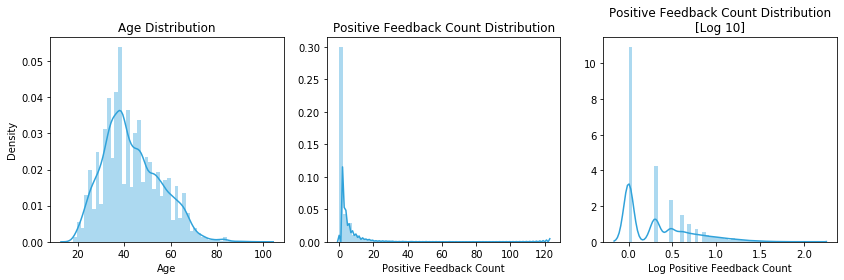

In [13]:
# Continous Distributions
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")
plt.tight_layout()
plt.show()

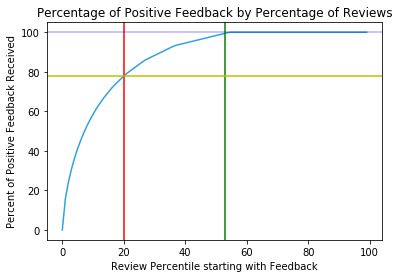

78.0% of Positive Feedback belongs to the top 20% of Reviews

Gini Coefficient: 0.76


In [14]:
# Percentage Accumulation from "Most Wealthy"
def percentage_accumulation(series, percentage):
    return (series.sort_values(ascending=False)
            [:round(series.shape[0]*(percentage/100))]
     .sum()/series
     .sum()*100)

# Gini Coefficient- Inequality Score

def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(df["Positive Feedback Count"], x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axvline(x=53, c = "g")
plt.axhline(y=78, c = "y")
plt.axhline(y=100, c = "b", alpha=.3)
plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(df["Positive Feedback Count"], 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(df["Positive Feedback Count"]),2)))

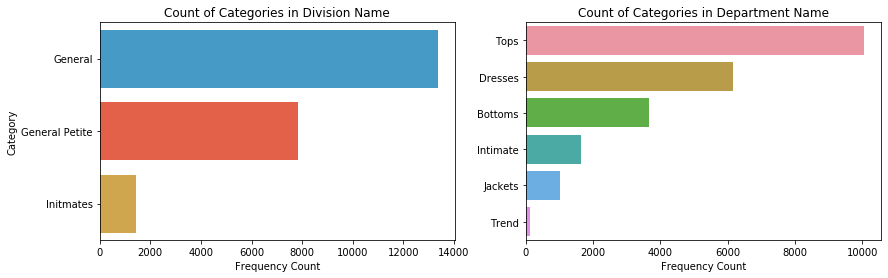

In [15]:
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df,order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

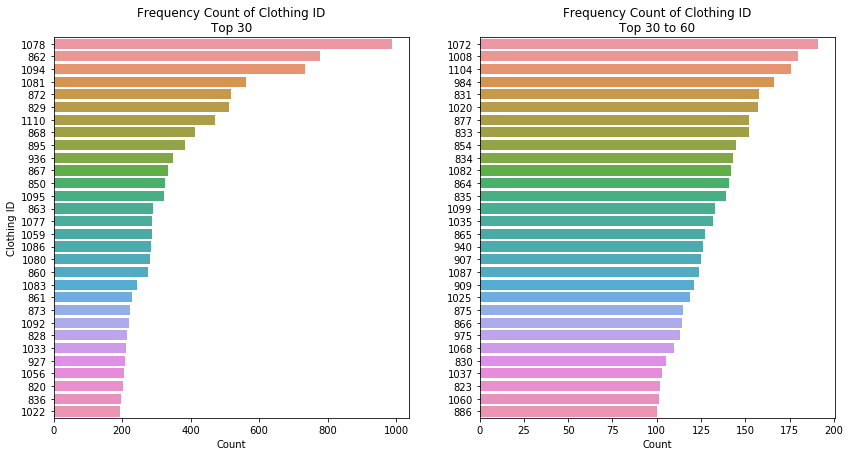

Dataframe Dimension: 22628 Rows


mean         std    min    25%     50%     75%  \
Clothing ID              1015.4848  103.396022  862.0  862.0  1078.0  1094.0   
Age                        42.7248   12.150429   18.0   34.0    41.0    51.0   
Rating                      4.1892    1.104306    1.0    4.0     5.0     5.0   
Recommended IND             0.8184    0.385592    0.0    1.0     1.0     1.0   
Positive Feedback Count     2.8624    6.773021    0.0    0.0     1.0     3.0   
Word Count                 60.5912   28.731486    2.0   36.0    60.0    89.0   
Character Count           310.8604  144.836158   16.0  189.0   305.0   469.0   
Label                       0.9024    0.296832    0.0    1.0     1.0     1.0   

                            max  
Clothing ID              1094.0  
Age                        99.0  
Rating                      5.0  
Recommended IND             1.0  
Positive Feedback Count    98.0  
Word Count                115.0  
Character Count           504.0  
Label                       1.0

In [16]:
# Clothing ID Category
f, axes = plt.subplots(1,2, figsize=[14,7])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
              order= df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order= df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel("")
axes[1].set_xlabel("Count")
plt.show()

print("Dataframe Dimension: {} Rows".format(df.shape[0]))
df[df["Clothing ID"].isin([1078, 862,1094])].describe().T.drop("count",axis=1)

In [17]:
df.loc[df["Clothing ID"].isin([1078, 862,1094]),
       ["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

unique              top  freq
Title             1815  Beautiful dress    21
Division Name        2          General  1524
Department Name      2          Dresses  1722
Class Name           2          Dresses  1722

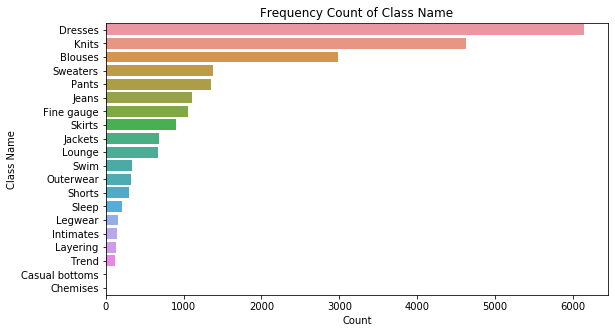

In [18]:
# Class Name
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

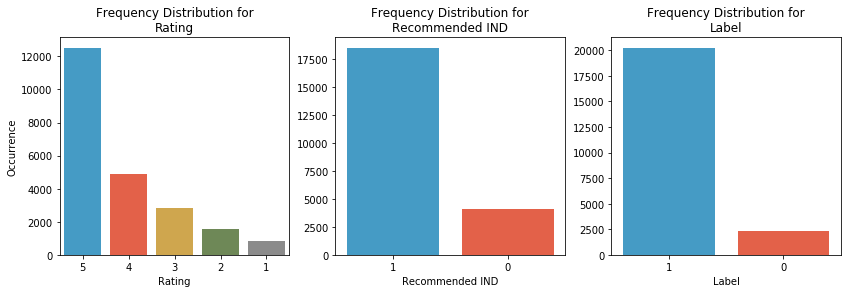

In [19]:
#cat_dtypes = [x for x,y,z in unique_count if y < 10 and x not in ["Division Name","Department Name"]]
cat_dtypes = ["Rating","Recommended IND","Label"]
increment = 0
f, axes = plt.subplots(1,len(cat_dtypes), figsize=(14,4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df,order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title("Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

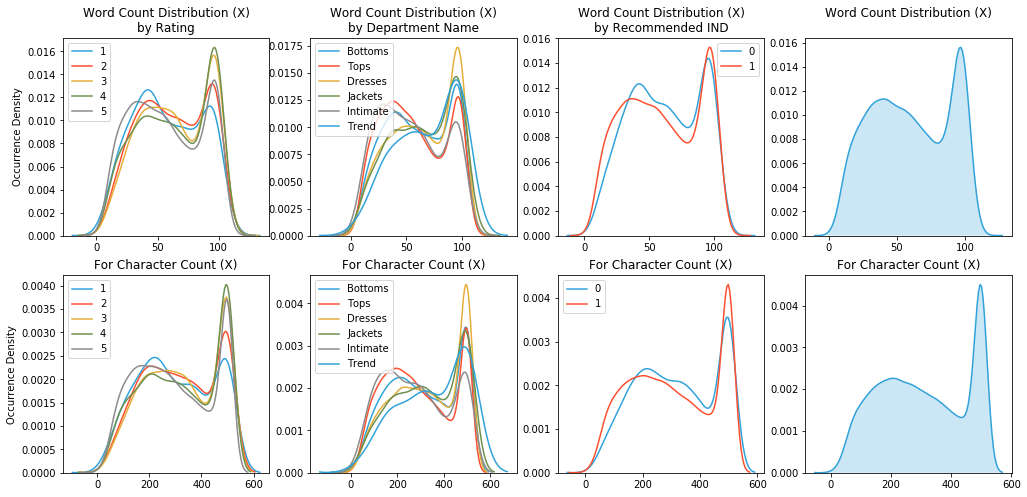

Correlation Coefficient of Word Cound and Character Count: 0.99

Total Word Count is: 1362476
Total Character Count is: 6986656


count        mean         std  min    25%    50%    75%  \
Word Count       22628.0   60.211950   28.533053  2.0   36.0   59.0   88.0   
Character Count  22628.0  308.761534  143.934126  9.0  186.0  302.0  459.0   

                   max  
Word Count       115.0  
Character Count  508.0

In [20]:
f, axes = plt.subplots(2,4, figsize=(17,8), sharex=False)
for ii, xvar in enumerate(['Word Count', "Character Count"]):
    for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
    axes[ii,0].set_ylabel('Occurrence Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,3])
    axes[ii,3].set_xlabel("")
    if ii is 0:
        axes[ii,3].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,3].set_title('For {} (X)'.format(xvar))
    axes[ii,3].legend_.remove()
plt.show()

print("Correlation Coefficient of Word Cound and Character Count: {}".format(
    round(df["Word Count"].corr(df["Character Count"]), 2)))

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
print("Total Character Count is: {}".format(df["Character Count"].sum()))
df[["Word Count","Character Count"]].describe().T

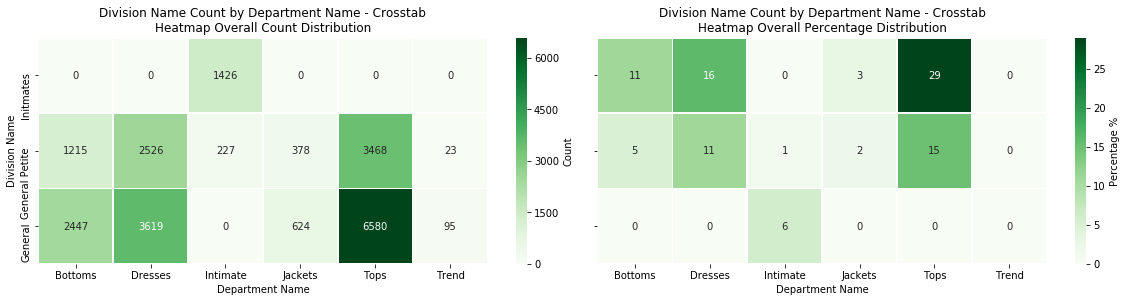

In [21]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

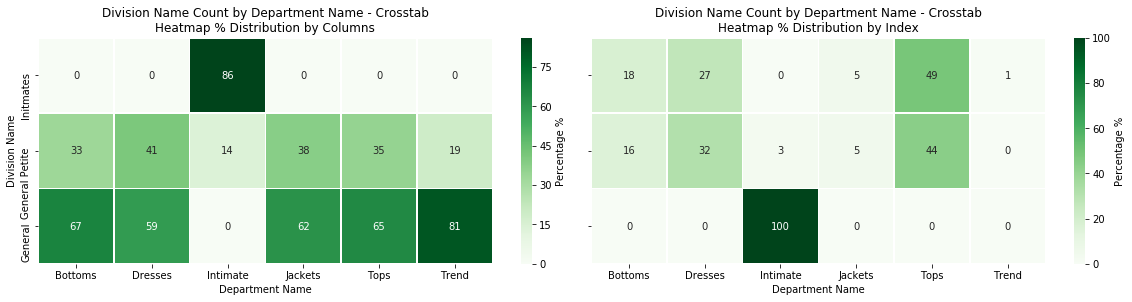

In [22]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='columns').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='index').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Index')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

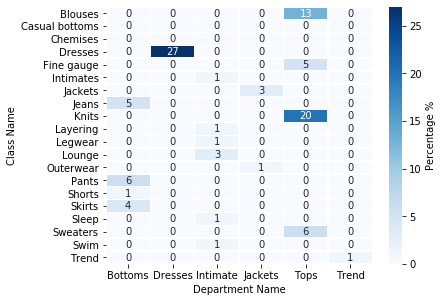

In [23]:
# Heatmaps of Percentage Pivot Table


sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, fmt='g', cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
plt.tight_layout(pad=0)
plt.show()

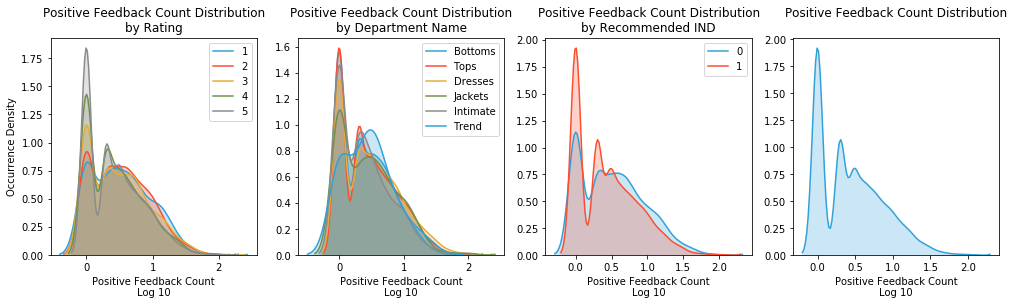

In [24]:
f, axes = plt.subplots(1,4, figsize=(17,4), sharex=False)
xvar = 'Positive Feedback Count'
plotdf = np.log10(df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=True, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))
axes[0].set_ylabel('Occurrence Density')
# Plot 4
sns.kdeplot(plotdf,shade=True,ax=axes[3])
axes[3].set_xlabel("{}\nLog 10".format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
axes[3].legend_.remove()
plt.show()

# here the recomended distribuation is less compared to positive rated count

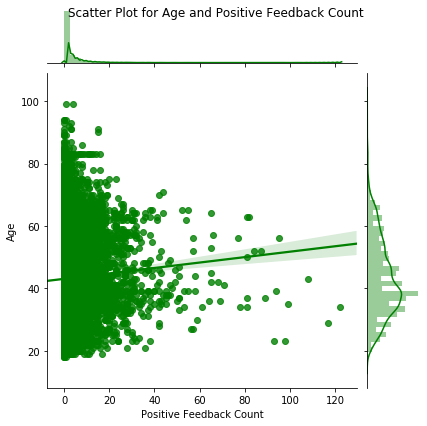

In [25]:
# Normalization is futile here.. But here is a minmax standardization, and a z-score normalization function. 
def minmaxscaler(df):
    return (df-df.min())/(df.max()-df.min())
def zscorenomalize(df):
    return (df - df.mean())/df.std()

g = sns.jointplot(x= df["Positive Feedback Count"], y=df["Age"], kind='reg', color='g')
g.fig.suptitle("Scatter Plot for Age and Positive Feedback Count")
plt.show()

In [26]:
def percentstandardize_barplot(x,y,hue, data, ax=None, order= None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")

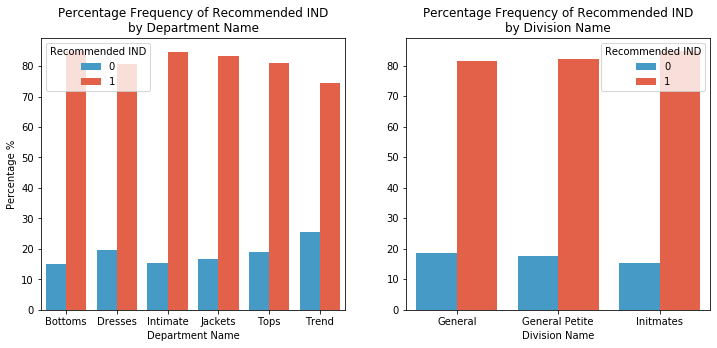

In [27]:
huevar = "Recommended IND"
f, axes = plt.subplots(1,2,figsize=(12,5))
percentstandardize_barplot(x="Department Name",y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby Department Name".format(huevar))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x="Division Name",y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby Division Name".format(huevar))
axes[1].set_ylabel("")
plt.show()

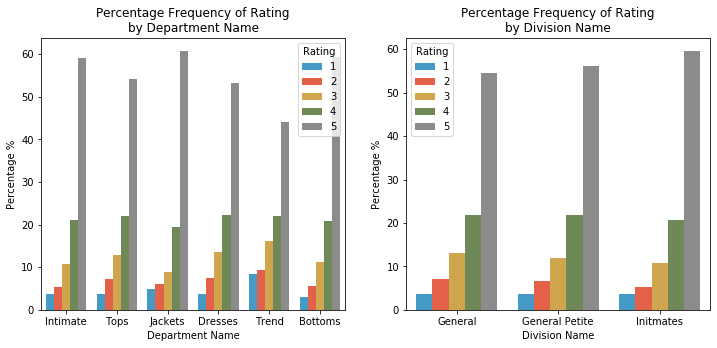

In [28]:
xvar = ["Department Name","Division Name"]
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(12,5))
percentstandardize_barplot(x=xvar[0],y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[0]))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x=xvar[1],y="Percentage", hue="Rating",data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[1]))
plt.show()

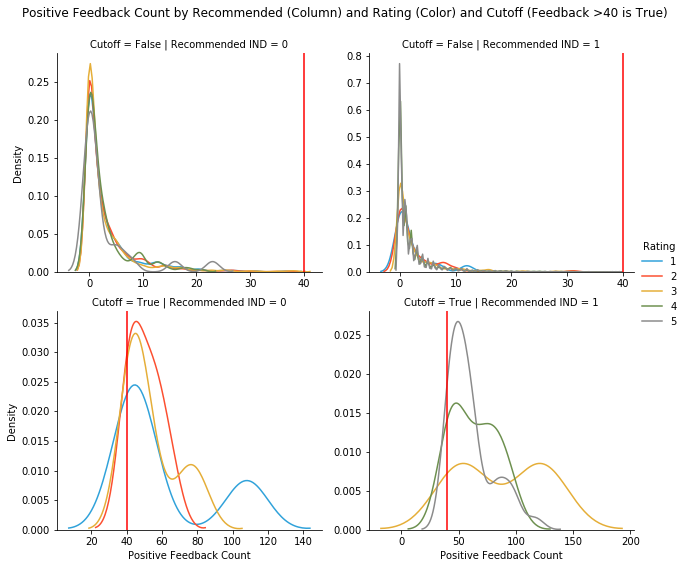

In [29]:
# Cuttoff Variable
df["Cutoff"] = df["Positive Feedback Count"] >= 40 # Temporary variable for facetgrid
# Facet Grid Plot
g = sns.FacetGrid(df, row = "Cutoff", col="Recommended IND",
                  hue="Rating", size=4, aspect=1.1, sharey=False, sharex=False)
g.map(sns.distplot, "Positive Feedback Count", hist=False)
g.add_legend()
g.axes[0,0].set_ylabel('Density')
g.axes[1,0].set_ylabel('Density')
plt.subplots_adjust(top=0.90)
g.fig.suptitle('Positive Feedback Count by Recommended (Column) and Rating (Color) and Cutoff (Feedback >40 is True)')

# Give cutoff line to each plot.
for x in [0,1]:
    for y in [0,1]:
        g.axes[x,y].axvline(x=40, c="r")

plt.show()
del df["Cutoff"]



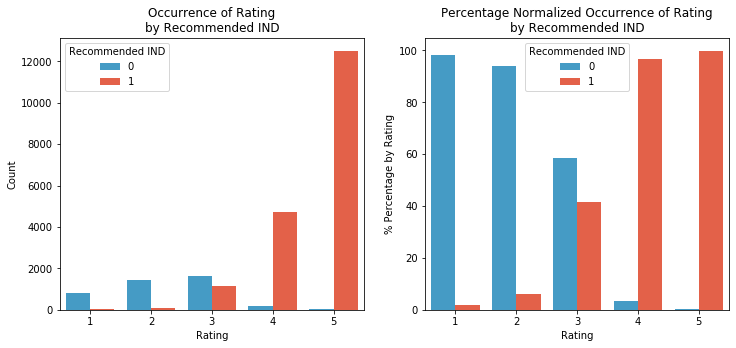

In [30]:
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x="Rating", hue="Recommended IND",data=df, ax=axes[0])
axes[0].set_title("Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x="Rating",y="Percentage", hue="Recommended IND",data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[1].set_ylabel("% Percentage by Rating")
plt.show()

In [31]:
temp = (df.groupby('Clothing ID')[["Rating","Recommended IND", "Age"]]
        .aggregate(['count','mean']))
temp.columns = ["Count","Rating Mean","Recommended IND Count",
                "Recommended Mean","Age Count","Age Mean"]
temp.drop(["Recommended IND Count","Age Count"], axis=1, inplace =True)


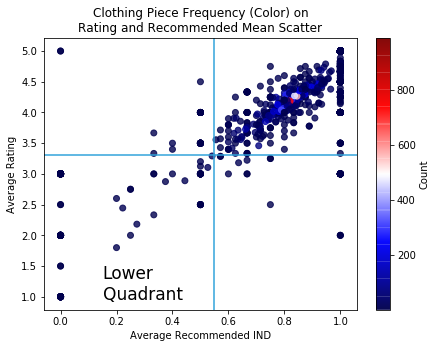

Count  Rating Mean  Recommended Mean    Age Mean
count  204.000000   204.000000        204.000000  204.000000
mean     2.308824     2.763338          0.316315   41.883954
std      2.798261     0.819220          0.351723   10.858979
min      1.000000     1.000000          0.000000   20.000000
25%      1.000000     2.136364          0.000000   34.687500
50%      1.000000     3.000000          0.250000   41.142857
75%      2.000000     3.000000          0.500000   47.000000
max     24.000000     5.000000          1.000000   74.000000

In [32]:
plt.figure(figsize=(7,5))
plt.scatter(temp["Recommended Mean"],temp["Rating Mean"],
            alpha = .8, c =temp["Count"], cmap = 'seismic')
cbar = plt.colorbar() # Color bar. Vive la France!
cbar.set_label('Count', rotation=90)
plt.xlabel("Average Recommended IND")
plt.ylabel("Average Rating")
plt.title("Clothing Piece Frequency (Color) on\nRating and Recommended Mean Scatter")

# Vertical and Horizontal Lines
l = plt.axhline(y=3.3)
l = plt.axvline(x=.55)

# Text
plt.text(.15, 1, "Lower\nQuadrant", ha='left',wrap=True,fontsize=17)
plt.show()

# Descriptives for LOW QUADRANT
temp[(temp["Rating Mean"] < 3.3) | (temp["Recommended Mean"] <= .55)].describe()

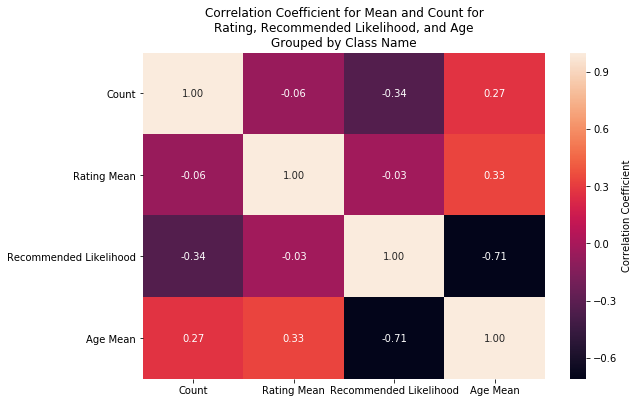

Class Categories:
 ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'Chemises']


In [33]:
key = "Class Name"
temp = (df.groupby(key)[["Rating","Recommended IND", "Age"]]
        .aggregate(['count','mean']))
temp.columns = ["Count","Rating Mean","Recommended Likelihood Count",
                "Recommended Likelihood","Age Count","Age Mean"]
temp.drop(["Recommended Likelihood Count","Age Count"], axis=1, inplace =True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(temp.corr()
    , annot=True, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Coefficient for Mean and Count for\nRating, Recommended Likelihood, and Age\nGrouped by {}".format(key))
plt.show()
print("Class Categories:\n",df["Class Name"].unique())

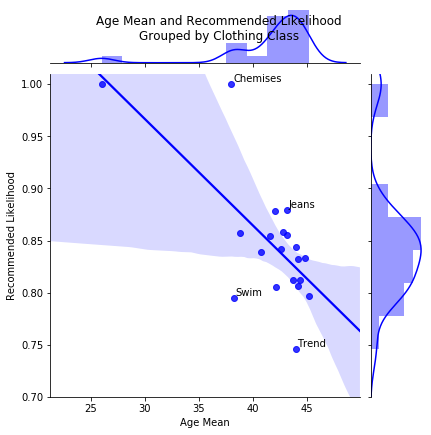

Count  Rating Mean  Recommended Likelihood  Age Mean     resid
Class Name                                                                    
Casual bottoms      1          4.0                     1.0      26.0 -0.007388
Chemises            1          4.0                     1.0      38.0  0.114893

In [34]:
# Simple Linear Regression Model
model_fit = sm.OLS(temp["Recommended Likelihood"],
               sm.add_constant(temp["Age Mean"])).fit() 
temp['resid'] = model_fit.resid

# Plot
g = sns.jointplot(y="Recommended Likelihood",x='Age Mean',data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle("Age Mean and Recommended Likelihood\nGrouped by Clothing Class")
plt.ylim(.7, 1.01)

# Annotate Outliers
head = temp.sort_values(by=['resid'], ascending=[False]).head(2)
tail = temp.sort_values(by=['resid'], ascending=[False]).tail(2)

def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=( r["Age Mean"], r["Recommended Likelihood"]), 
            xytext=(2,2) , textcoords ="offset points", )

for row in head.iterrows():
    ann(row)
for row in tail.iterrows():
    ann(row)

plt.show()
del head, tail

temp[temp["Recommended Likelihood"] > .95]

In [35]:


pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].head(7)

Title  \
0                      NaN   
1                      NaN   
2  Some major design flaws   
3         My favorite buy!   
4         Flattering shirt   
5  Not for the very petite   
6     Cagrcoal shimmer fun   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Review Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                Absolutely wonderful - silky and sexy and comfortable   
1                                                                                                                                                                                                      Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.   
2  I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...   
3                                                                                                                                                                                                                                                                                                                                                                                         I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!   
4                                                                                                                                                                                                                                                                                                                     This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!   
5             I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.   
6     I aded this in my basket at hte last mintue to see what it would look like in person. (store pick up). i went with teh darkler color only because i am so pale :-) hte color is really gorgeous, and turns out it mathced everythiing i 

In [36]:


pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].sample(7)

Title  \
19206         What's with the length?   
9760                Comfortable style   
6879                  Wonderful pants   
6112                    Individuality   
6640   Fun and hip, but not too young   
14149           Like a bolt of fabric   
10141           Painful but beautiful   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Review Text  \
19206                                             So i haven't actually tried this and i'm sorry for the misleading star rating. i just wanted to get someone's attention on the length. the photos show the dress draping with almost a train even with the model in platform heels but in the video, the dress is about 2 inches off the floor. is it the model in the video that is extra tall? someone help me out. this looks gorgeous but since it's an online exclusive, i won't be able to try it on at the store.   
9760   Such a great purchase! the fit is so flattering to my 5'3" frame. i usually wear an extra small/small, but i opted for an extra small after reading a review; i'm glad i did. i also did not get the petite, but i imagine it would have a similar fit without the length this has. it flows, yet hits my curves in all the right places. i will say, i'm a c cup and if you have larger breasts, the extra small may not accommodate them as it is just right on me. the black is so slimming especially when p...   
6879      Just wanted to add my comments to the review that stated these pants ran small in the waist.  i sized up because of that review and ordered an extra large as i wanted these to be loose and comfortable. i typically am a m/l in retailer.  the xl is actually a little big but not enough that i need to return them. if you order these in a fit that is fairly loose, these are not see through at all. (i ordered the color shown on the model) i am about 5 feet 4 so the pants are not as cropped on me .   
6112                                                                                                                                    Great buy. i bought the cream jumpsuit.  i'm small on bottom and larger on top. this was perfect, shouldn't fit tight, should flow, has lots of room, it is linen, adjustable buttons on front and adjustable on the back of jumpsuit. legs are wide and flowy. casual but classy. both sides have about 3 buttons at hips. great addition to any closet. unique in its own right.   
6640                                                                                                                                                               At 46 years old, i still like fun, hip, fashionable items, but i don't want to look like i raided my 21 year old daughter's closet. this jacket hits the mark perfectly. it looks great layered over a casual dress or with skinny jeans and a wedge. the embroidery and the back tie soften the masculine color and shape. i'll be wearing this often!   
14149                                                                                                                                                                                                                                     Like the previous review said, i was excited to receive this top. i had grand visions of all the ways i could wear it! to my chagrin, when i put it on, it just fell right down and pooled around my waist. i wish there were smaller sizes to order. sadly, this is going back.   
10141                                                                                                                                

In [37]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4
    return words

In [38]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

In [39]:
df.sample(5)

Clothing ID  Age                                   Title  \
10985         1107   41                        Cute! not for me   
21224          854   61  Gaps at the top button - but so pretty   
2049          1092   39               Flowy, functional ,dressy   
4888           826   41                    Absolutely beautiful   
23374         1110   66                        Wonky fitted top   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Review Text  \
10985                                                                                                                                                                                                                                                                                                                            It looks so cute and i love the detail on this dress but it was not flattering on me. light summer dress and that was exactly what i needed but i had to exchange it with something else.   
21224                                                                                                                                                                                                                                                                                                                                                This blouse is very pretty, but it does gap at the top button. darn! such a hassle to have to return it, or exchange it. but i love it and otherwise it seems to fit.   
2049   I love the ease of this dress. the style can be dressed up or down. the straps are inset a little which doesn't work for every body type. the thin material can get caught and snag easily but otherwise this dress is a simple chic addition to my closet. the length is just right, not too long like some other maxi dresses. the lining underneath ends at the perfect length as well. the top part is lined well so it can be worn with or without a bra. i am normally a 4 or 6 in dresses. the waistband ...   
4888                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Got the green one   
23374   I love the material & flow of the bottom half of this dress, it fits like a charm.  for reference i am a 34-29-38/39, the size 6 was spot on. that being said, i was a little disappointed by the top portion of the dress; the dolman sleeve seems odd & the faux wrap is gaping & doesn't seem to clip in the right spot, sloppy, not like on the model. the dress would be perfect as a full sleeve & a little snugger of a wrap. i could alter the top, but the material just wouldn't lay right to the waist.   

       Rating  Recommended IND  Positive Feedback Count   Division Name  \
10985       3                1                        0         General   
21224       3                0                        1  General Petite   
2049        5                1                        0  General Petite   
4888        5                1                        0  General Petite   
23374       4                1                        0  General Petite   

      Department Name Class Name  Word Count  Character Count  Label  \
10985         Dresse

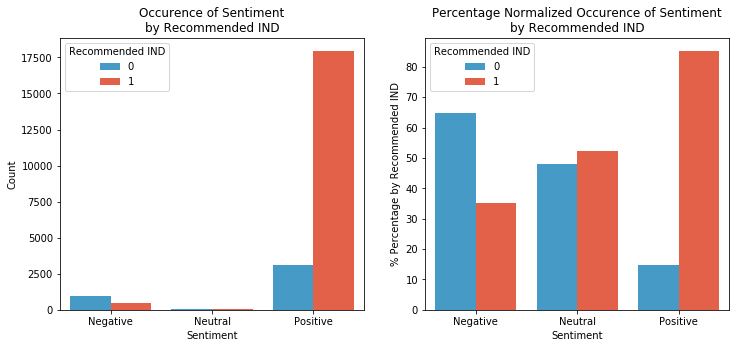

In [40]:
huevar = "Recommended IND"
xvar = "Sentiment"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Occurence of {}\nby {}".format(xvar, huevar))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurence of {}\nby {}".format(xvar, huevar))
axes[1].set_ylabel("% Percentage by {}".format(huevar))
plt.show()

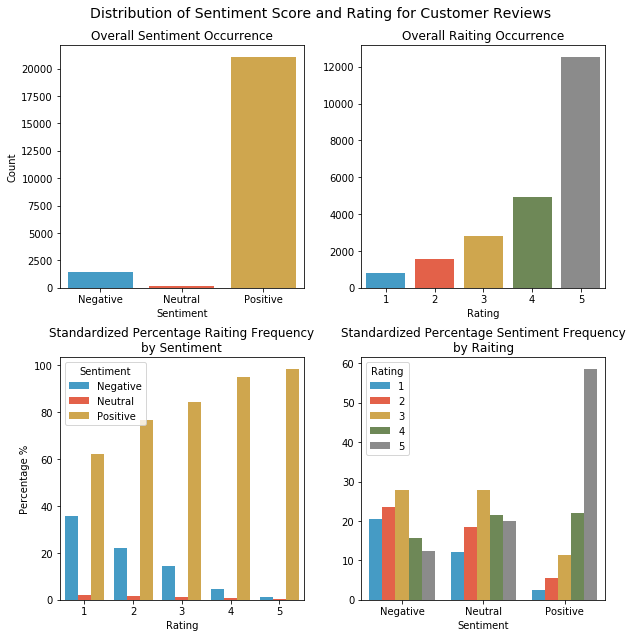

In [41]:
f, axes = plt.subplots(2,2, figsize=[9,9])
sns.countplot(x="Sentiment", data=df, ax=axes[0,0], order=["Negative","Neutral","Positive"])
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")
axes[0,0].set_title("Overall Sentiment Occurrence")

sns.countplot(x="Rating", data=df, ax=axes[0,1])
axes[0,1].set_xlabel("Rating")
axes[0,1].set_ylabel("")
axes[0,1].set_title("Overall Raiting Occurrence")

percentstandardize_barplot(x="Rating",y="Percentage",hue="Sentiment",data=df, ax=axes[1,0])
axes[1,0].set_xlabel("Rating")
axes[1,0].set_ylabel("Percentage %")
axes[1,0].set_title("Standardized Percentage Raiting Frequency\nby Sentiment")

percentstandardize_barplot(x="Sentiment",y="Percentage",hue="Rating",data=df, ax=axes[1,1])
axes[1,1].set_ylabel("Occurrence Frequency")
axes[1,1].set_title("Standardized Percentage Sentiment Frequency\nby Raiting")
axes[1,1].set_xlabel("Sentiment")
axes[1,1].set_ylabel("")

f.suptitle("Distribution of Sentiment Score and Rating for Customer Reviews", fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.92)
plt.show()

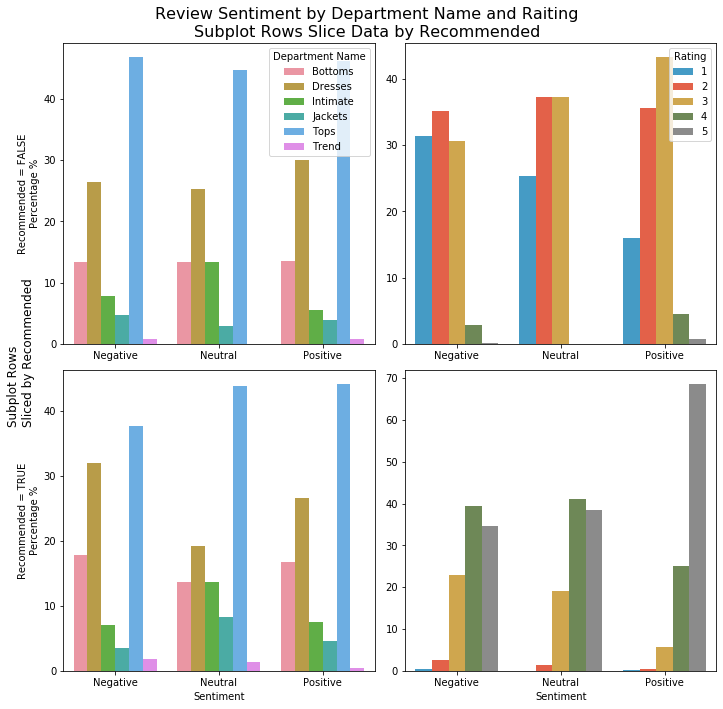

In [42]:
# Tweakable Variables (Note to Change Order Arguement if Xvar is changed)
xvar = "Sentiment"
huevar = "Department Name"
rowvar = "Recommended IND"

# Plot
f, axes = plt.subplots(2,2,figsize=(10,10), sharex=False,sharey=False)
for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df[df[rowvar] == x],
                 ax=axes[i,0], order=["Negative","Neutral","Positive"])
    percentstandardize_barplot(x=xvar,y="Percentage", hue="Rating",data=df[df[rowvar] == x],
                 ax=axes[i,1], order=["Negative","Neutral","Positive"])

# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,0].set_ylabel("Recommended = FALSE\nPercentage %")
axes[1,0].set_ylabel("Recommended = TRUE\nPercentage %")
axes[1,1].set_title("")

# Common title and ylabel
f.text(0.0, 0.5, 'Subplot Rows\nSliced by Recommended', va='center', rotation='vertical', fontsize=12)
f.suptitle("Review Sentiment by Department Name and Raiting\nSubplot Rows Slice Data by Recommended", fontsize=16)
f.tight_layout()
f.subplots_adjust(top=0.93)
plt.show()

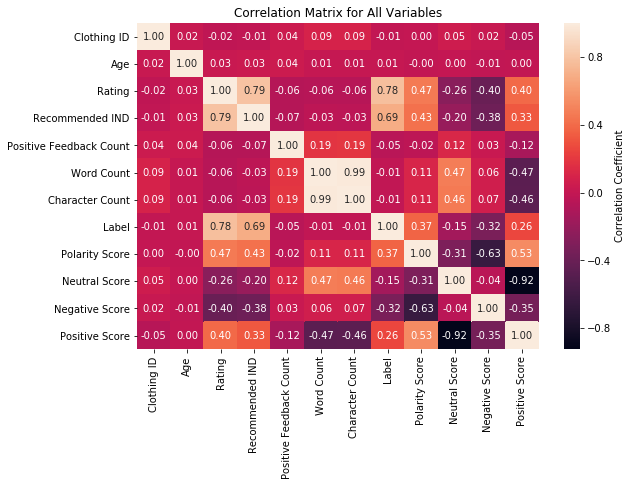

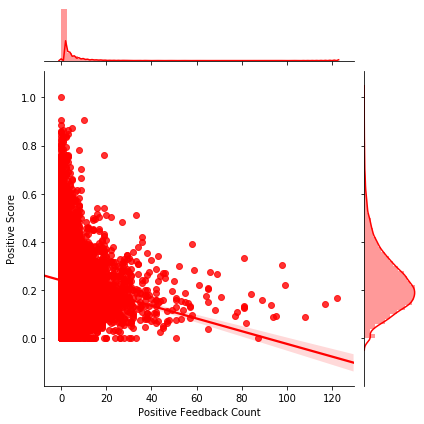

In [43]:
# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(df.corr(), annot=True,
                 fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Matrix for All Variables")
plt.show()

# Sentiment Positivity Score by Positive Feedback Count
ax = sns.jointplot(x= df["Positive Feedback Count"], y=df["Positive Score"], kind='reg', color='r')
plt.show()

In [44]:
stopwords = set(STOPWORDS)
size = (10,7)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Frequency Calculation [One-Gram]
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

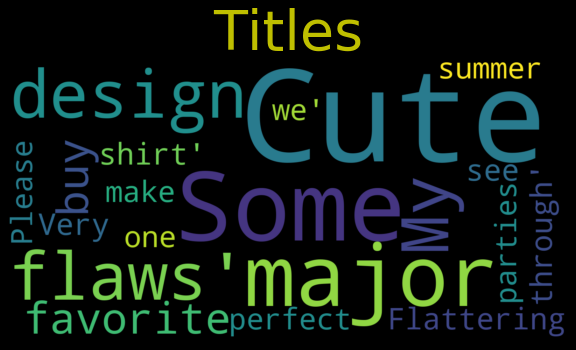

In [45]:
# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= df.Title[df.Title.notnull()].astype(str).values,
      title="Titles",
      stopwords= new_stop,
      size = (7,4))

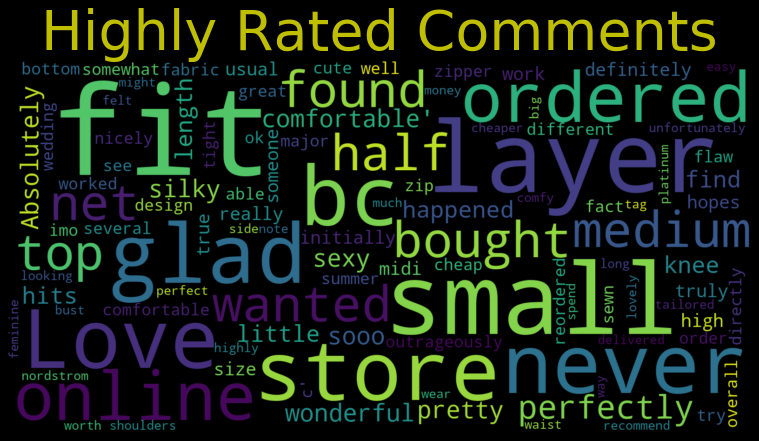

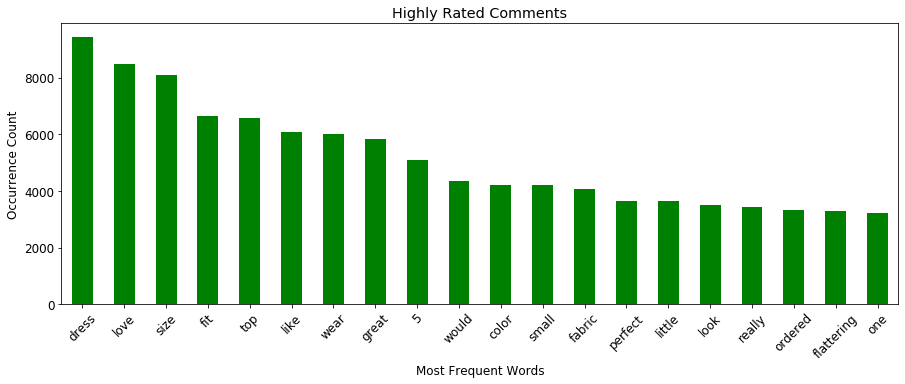

In [46]:
# Highly Raited
title ="Highly Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) >= 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

# Bar Chart
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()



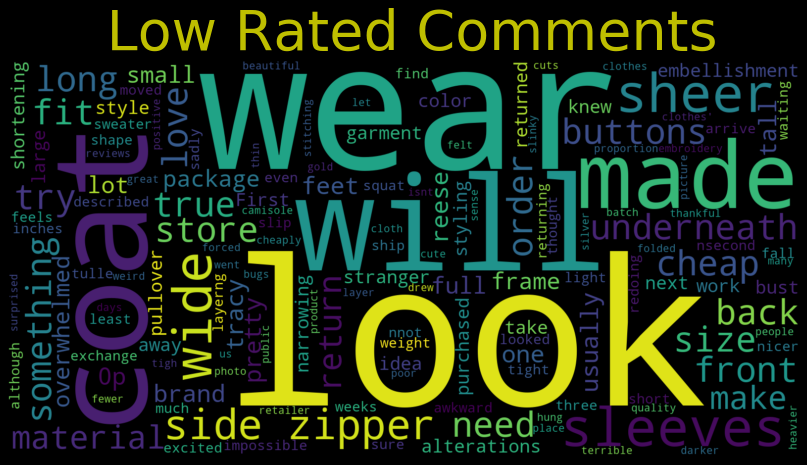

In [47]:
# Low Raited
title =" Low Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) < 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite", "skirt","shirt"])

# Cloud
cloud(temp.values, title= title, stopwords = new_stop)

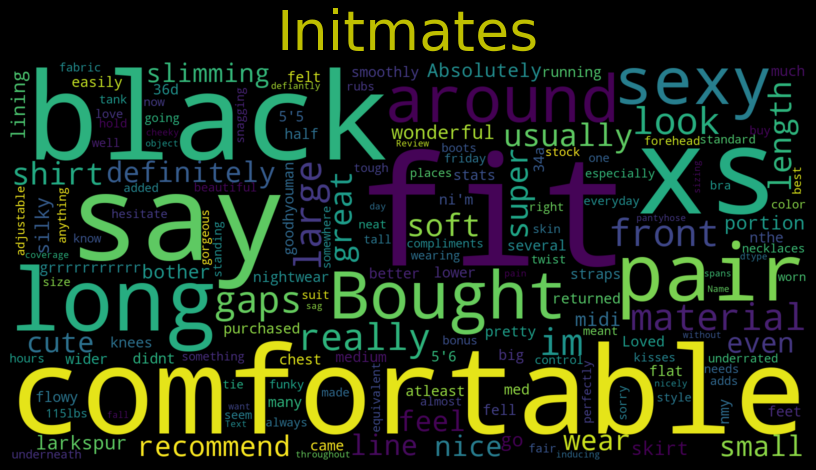

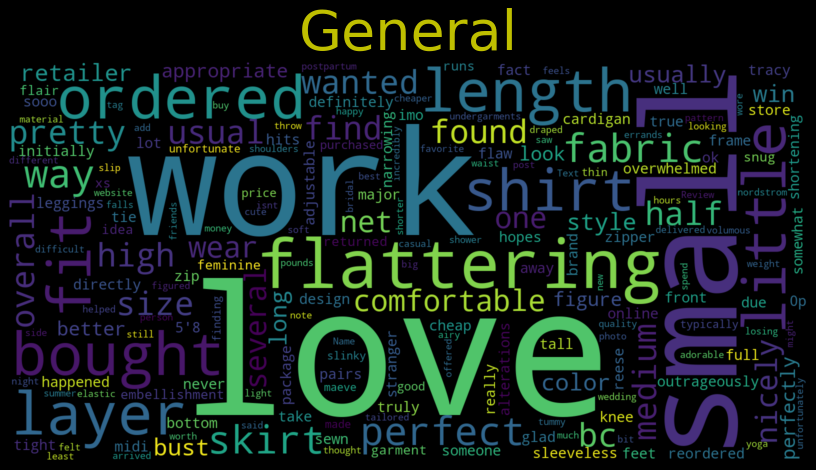

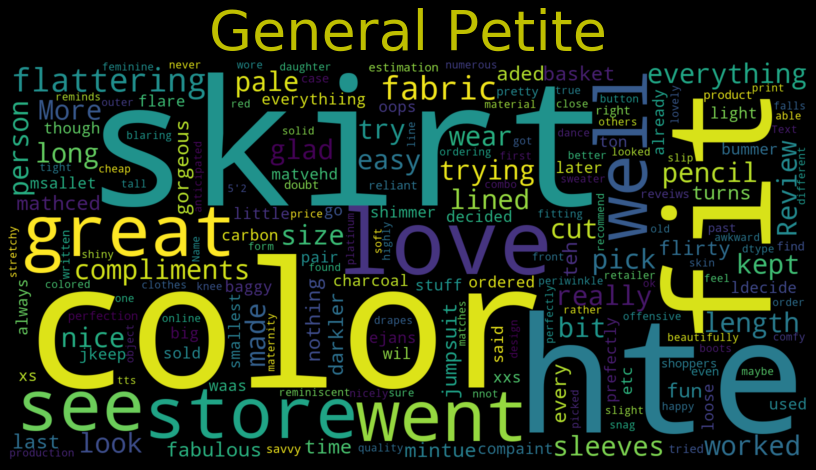

In [48]:
department_set = df["Department Name"][df["Department Name"].notnull()].unique()
division_set = df["Division Name"][df["Division Name"].notnull()].unique()
def cloud_by_category(data, category, subclass):
    """
    Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable
    """
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(data["Class Name"][data["Class Name"].notnull()].unique())]
                   + [x.lower() for x in list(data["Department Name"][data["Department Name"].notnull()].unique())]
                   + ["dress", "petite", "jacket","top"])

    # Cloud
    cloud(text= data["Review Text"][data[category]== subclass],
          title="{}".format(subclass),
          stopwords= new_stop,
          size = (10,6))
    
# Plot
cloud_by_category(df, "Division Name", division_set[0])
cloud_by_category(df, "Division Name", division_set[1])
cloud_by_category(df, "Division Name", division_set[2])

In [49]:
# Helper Functions
from nltk.util import ngrams
from collections import Counter
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(data),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurrence"]
        out = pd.concat([out, table], axis=1)
    return out

In [50]:
print("Non-Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 0], gram=[1,2,3,4,5], length=30)

Non-Recommended Items


1-Gram  Occurrence         2-Gram  Occurrence                  3-Gram  \
0      dress        1976    wanted love         243      really wanted love   
1       like        1780     going back         215       wanted love dress   
2        top        1572    looked like         187      really wanted like   
3      would        1348     looks like         153          made look like   
4        fit        1327  really wanted         151         wanted love top   
5     fabric        1245      made look         135           fit true size   
6       size        1209      look like         126      ordered usual size   
7       back        1039            5 4         113         way much fabric   
8       look         965      felt like         109        sadly going back   
9       love         928      true size         104      like maternity top   
10     small         910   usually wear         103       usually wear size   
11         5         871     love dress          95          one going back   
12    really         869    much fabric          89         first time wore   
13   ordered         825            5 5          88         would look good   
14      wear         756       fit well          81     looked like wearing   
15  material         736     size small          80       looks great model   
16      much         721  thought would          80   looked like maternity   
17     color         717            5 7          79      looks nothing like   
18     shirt         687            5 2          79       excited get dress   
19       one         647      well made          76         wanted like top   
20       way         645            5 8          75       felt like wearing   
21      also         643            5 3          73  really looking forward   
22     looks         622  ordered small          71          make look like   
23      even         602     would look          71       would look better   
24    looked         589     runs small          70           reference 5 5   
25   quality         559     runs large          69        high hopes dress   
26      cute         538      arm holes          68     wanted love sweater   
27     large         538    reference 5          67        would fit better   
28     great         530            5 6          66          high hopes top   
29      made         524     usual size          65                 5 4 120   

    Occurrence                          4-Gram  Occurrence  \
0           70        really wanted love dress          15   
1           65       looked like maternity top          10   
2           40        really wanted like dress           9   
3           29          really wanted like top           9   
4           28                     5 4 120 lbs           8   
5           28          really wanted love top           7   
6           25                     5 7 140 lbs           6   
7           25           measurements 38 30 40           6   
8           24        going back really wanted           6   
9           23       would look better someone           5   
10          23        ordered usual size small           5   
11          20          wanted love dress much           5   
12          18        really wanted love shirt           5   
13          16        looks like maternity top           5   
14          16         back really wanted like           5   
15          15                     5 5 122 lbs           4   
16          15         made look like pregnant           4   
17          14         maybe would look better           4   
18          14  really looking forward wearing           4   
19          14                     5 7 115 lbs           4   
20          14                     5 8 140 lbs           4   
21          13       online ordered right away           4   
22          13      like another reviewer said           4   
23          13          going back wanted love           4   
24    

In [51]:
print("Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 1], gram=[1,2,3,4,5], length=30)

Recommended Items


1-Gram  Occurrence            2-Gram  Occurrence  \
0         dress        8591         true size        1243   
1          love        8017        love dress         657   
2          size        7561               5 4         622   
3           fit        5995      usually wear         588   
4           top        5846       looks great         574   
5          wear        5678     fit perfectly         553   
6         great        5584         well made         531   
7          like        5368          love top         524   
8             5        4678               5 3         488   
9         color        3887    fits perfectly         480   
10        small        3816               5 5         444   
11        would        3760         love love         417   
12      perfect        3572        usual size         411   
13       fabric        3552               5 2         409   
14       little        3410        size small         408   
15         look        3074               5 7         378   
16   flattering        3065               5 6         377   
17       really        3055  many compliments         362   
18         soft        3041  highly recommend         361   
19      ordered        3025            size 4         340   
20          one        2989        super cute         325   
21         well        2934            size 6         322   
22  comfortable        2886      skinny jeans         319   
23         fits        2685       fabric soft         315   
24       bought        2684         fit great         314   
25         nice        2609        super soft         313   
26          bit        2557  soft comfortable         312   
27         cute        2504               5 8         309   
28    beautiful        2495   absolutely love         307   
29       length        2342         wear size         298   

                        3-Gram  Occurrence                       4-Gram  \
0               fits true size         264  compliments every time wear   
1                fit true size         192             26 waist 36 hips   
2    received many compliments         163              34b 26 waist 36   
3               runs true size         143     looks great skinny jeans   
4               love love love         138   get compliments every time   
5            usually wear size         107         love love love dress   
6              every time wear          81                115 lbs 30 dd   
7           ordered usual size          79          usually wear size 4   
8          small fit perfectly          72                  5 4 120 lbs   
9         got many compliments          70               5 5 135lbs 34c   
10           looks great jeans          69         dress fits true size   
11        small fits perfectly          65                  5 4 125 lbs   
12          usually wear small          64            2 currently 33 25   
13             fits like glove          64             5 2 currently 33   
14              fit like glove          64              30dd 26 5 waist   
15          normally wear size          59  compliments first time wore   
16  would definitely recommend          57              115 lbs 30dd 26   
17                 true size 5          57                  5 4 135 lbs   
18         usually wear medium          56                  5 3 120 lbs   
19             runs little big          55                 lbs 30 dd 26   
20        local retailer store          53           love love love top   
21            usual size small          53          usually wear size 6   
22      compliments every time          53                   30 dd 26 5   
23            wish came colors          52    usually wear small medium   
24               run true size          52           top fits true size   
25             first time wore          51           3 4 length sleeves   
26           runs little large          50     ordered usual size small   
27          great

In [52]:
df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurrence from whole block of text

vocab_count = 200
word_features= list(all_words.keys())[:vocab_count] # 200 most recurring unique words
print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))

Number of words columns (One Hot Encoding): 14034


In [53]:
print("Number of most freq words columns (One Hot Encoding): {}".format(len(word_features)))

Number of most freq words columns (One Hot Encoding): 200


In [54]:
print("Number of most freq words columns (One Hot Encoding): {}".format((word_features)))

Number of most freq words columns (One Hot Encoding): ['absolutely', 'wonderful', 'silky', 'sexy', 'comfortable', 'love', 'dress', 'sooo', 'pretty', 'happened', 'find', 'store', 'glad', 'bc', 'never', 'would', 'ordered', 'online', 'petite', 'bought', '5', '8', 'length', 'hits', 'little', 'knee', 'definitely', 'true', 'midi', 'someone', 'truly', 'high', 'hopes', 'really', 'wanted', 'work', 'initially', 'small', 'usual', 'size', 'found', 'outrageously', 'fact', 'could', 'zip', 'reordered', 'medium', 'ok', 'overall', 'top', 'half', 'fit', 'nicely', 'bottom', 'tight', 'layer', 'several', 'somewhat', 'cheap', 'net', 'layers', 'imo', 'major', 'design', 'flaw', 'sewn', 'directly', 'zipper', 'c', 'jumpsuit', 'fun', 'flirty', 'fabulous', 'every', 'time', 'wear', 'get', 'nothing', 'great', 'compliments', 'shirt', 'flattering', 'due', 'adjustable', 'front', 'tie', 'perfect', 'leggings', 'sleeveless', 'pairs', 'well', 'cardigan', 'tracy', 'reese', 'dresses', 'one', 'feet', 'tall', 'usually', '0p',

In [55]:
#Tuple
labtext= list(zip(df.tokenized, (df["Recommended IND"]))) 
# Function to create model features
# for each review, records which unique words out of the whole text body are present
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features
# Apply function to data
featuresets = [(find_features(text), LABEL) for (text, LABEL) in labtext]
len(featuresets)

# Train/Test
training_set = featuresets[:15000]
testing_set = featuresets[15000:]

In [56]:
featuresets[15000:]

[({'absolutely': False,
   'wonderful': False,
   'silky': False,
   'sexy': False,
   'comfortable': False,
   'love': False,
   'dress': False,
   'sooo': False,
   'pretty': False,
   'happened': False,
   'find': False,
   'store': False,
   'glad': False,
   'bc': False,
   'never': True,
   'would': True,
   'ordered': False,
   'online': False,
   'petite': False,
   'bought': False,
   '5': False,
   '8': False,
   'length': False,
   'hits': False,
   'little': False,
   'knee': False,
   'definitely': False,
   'true': False,
   'midi': False,
   'someone': False,
   'truly': False,
   'high': False,
   'hopes': False,
   'really': False,
   'wanted': False,
   'work': False,
   'initially': False,
   'small': False,
   'usual': False,
   'size': False,
   'found': False,
   'outrageously': False,
   'fact': False,
   'could': False,
   'zip': False,
   'reordered': False,
   'medium': False,
   'ok': False,
   'overall': False,
   'top': False,
   'half': False,
   'fit': Fa

In [57]:
# Posterior = prior_occurrence * likelihood / evidence
classifier = nltk.NaiveBayesClassifier.train(training_set)

# Output
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
print(classifier.show_most_informative_features(40))

# we use it to find the words indicate the positve and negative sentimate words throgh recomended features and depending on basyian propaplistic not-recommended (0:1), or recommended (1:0).

Classifier accuracy percent: 82.48557944415312
Most Informative Features
                   cheap = True                0 : 1      =     12.3 : 1.0
                    glad = True                1 : 0      =      5.4 : 1.0
                  bummer = True                0 : 1      =      5.0 : 1.0
                     net = True                0 : 1      =      4.6 : 1.0
                    idea = True                0 : 1      =      4.4 : 1.0
                  pencil = True                1 : 0      =      4.3 : 1.0
                 perfect = True                1 : 0      =      3.8 : 1.0
                 shimmer = True                1 : 0      =      3.7 : 1.0
                charcoal = True                1 : 0      =      3.7 : 1.0
                     fun = True                1 : 0      =      3.4 : 1.0
                   later = True                1 : 0      =      3.0 : 1.0
                    sooo = True                0 : 1      =      2.6 : 1.0
                     ton = 

In [58]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scikitplot as skplt
import eli5

Using TensorFlow backend.


In [59]:
vect = TfidfVectorizer()
vect.fit(df["Review Text"])
X = vect.transform(df["Review Text"])
y = df["Recommended IND"].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=23, stratify=y)

In [60]:
print(X_valid)

  (0, 13533)	0.3986526573094147
  (0, 13516)	0.4149332408452904
  (0, 13440)	0.0898412106075767
  (0, 12898)	0.13992364439089577
  (0, 12554)	0.22656220825791867
  (0, 12534)	0.11810966752422959
  (0, 11470)	0.20542969478812406
  (0, 11440)	0.07751911290924042
  (0, 11192)	0.0896642313824195
  (0, 10053)	0.3340291228665969
  (0, 9076)	0.14007295134477118
  (0, 8658)	0.12155511182956158
  (0, 8604)	0.17356367430974784
  (0, 8527)	0.07220753859183926
  (0, 7392)	0.08493625889613508
  (0, 6653)	0.15313251373316952
  (0, 6638)	0.1115051134354285
  (0, 6363)	0.06443922536907108
  (0, 6177)	0.28259596608455284
  (0, 5689)	0.18159931276368954
  (0, 5034)	0.11692771983572821
  (0, 4975)	0.09213808329319528
  (0, 4940)	0.16989806273650365
  (0, 3180)	0.1422688434450744
  (0, 2846)	0.12192057102115156
  :	:
  (4525, 8216)	0.12273877812700519
  (4525, 7718)	0.10172613457496246
  (4525, 7685)	0.07080327733051914
  (4525, 7675)	0.13849527511844548
  (4525, 7325)	0.16736830008434078
  (4525, 7197)	0

In [61]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
print("Train Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_train), y_train)))
print("Train Set ROC: {}\n".format(metrics.roc_auc_score(model.predict(X_train), y_train)))

print("Validation Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_valid), y_valid)))
print("Validation Set ROC: {}".format(metrics.roc_auc_score(model.predict(X_valid), y_valid)))

Train Set Accuracy: 0.9129377969285162
Train Set ROC: 0.8889105042166693

Validation Set Accuracy: 0.8915156871409633
Validation Set ROC: 0.8423407868220376


In [62]:
print(metrics.classification_report(model.predict(X_valid), y_valid))

              precision    recall  f1-score   support

           0       0.56      0.78      0.65       597
           1       0.96      0.91      0.94      3929

    accuracy                           0.89      4526
   macro avg       0.76      0.84      0.79      4526
weighted avg       0.91      0.89      0.90      4526



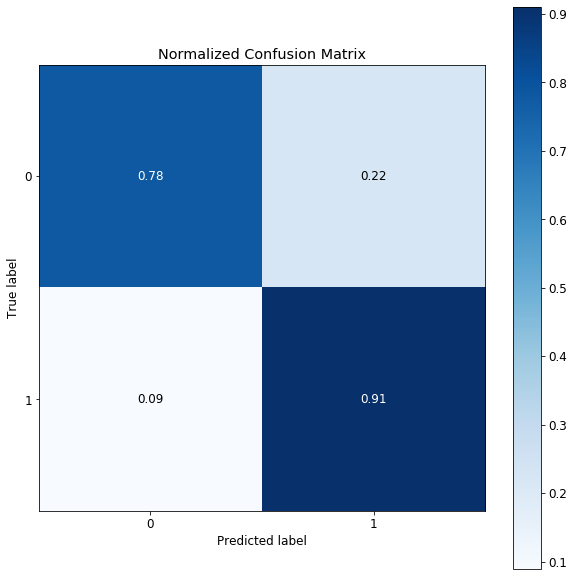

In [63]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(model.predict(X_valid), y_valid, normalize=True)
plt.show()

In [64]:
target_names = ["Not Recommended","Recommended"]
eli5.show_weights(model, vec=vect, top=100,
                  target_names=target_names)

In [65]:
for iteration in range(15):
    samp = random.randint(1,df.shape[0])
    print("Real Label: {}".format(df["Recommended IND"].iloc[samp]))
    display(eli5.show_prediction(model,df["Review Text"].iloc[samp], vec=vect,
                         target_names=target_names))

Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 0


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


Real Label: 1


In [ ]:
#refrence https://www.kaggle.com/nicapotato/guided-numeric-and-text-exploration-e-commerce